In [1]:
#load libraries
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from matplotlib.pyplot import figure
import re

global variables in the following cell need to be checked for every run

In [2]:
#some cheeky GLOBAL VARIABLES HERE
# this cell needs adjustments from run to run, depending which files one wants to investigate

# all 45 deg incidence:
#signal file numbers to use:
# 9  --> Graphite SS 40-1500 eV
# 10 --> Gold 40-1500 eV, regions 1-4 (stopped due to saturation)
# 11 --> Gold 40-1500 eV, regions 5 and 6 (the rest)
# 12 --> Gold 5-45 eV, all 7 regions
# 13 --> Graphite 5-45 eV

eV = 1.602e-19 #C, elementary charge

function to read data from a text file:

In [3]:
#This function simply reads a BEAR output text file with data and outputs it as a bunch of lists
def read_file(filename):
    #just declaring a list for each column
    phot_E = [] #eV
    I_sample = [] # INSTR_1, Kiethley B: instrument 1 with sample + bias, current
    I_monitor = [] # INSTR_2, Kiethley A, instrument 2 (monitor)
    I_diode=[]

    copy_lines = []
    with open (filename, "r", encoding='windows-1254') as myfile: #encoding change resolves an error coming from an extra \n at the end of files
        for l in myfile: #read lines until first occurence of this long line
            if "range keithley A" in l: #read in Keithley A range
                line = l.strip() 
                line = re.split(r' ', line)
                KA_range = line[-2] + line[-1]

            if "range keithley B" in l: #read in Keithley B range
                line = l.strip() 
                line = re.split(r' ', line)
                KB_range = line[-2] + line[-1]
            
            if "range keithley C" in l: #read in Keithley C range
                line = l.strip() 
                line = re.split(r' ', line)
                KC_range = line[-2] + line[-1]

            if "______________________________________________" in l:
                break
        for l in myfile: #read the file again until this appears
            if "______________________________________________" in l:
                break

        for l in myfile: #from then on, read all non-empty lines and split them on tab
            if l != "\n":
                line = l.strip() 
                line = re.split(r'\t+', line)
                copy_lines.append(line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1):
        line = copy_lines[i]

        phot_E.append(line[1])
        I_sample.append(line[4])
        I_monitor.append(line[5])
        I_diode.append(line[6])

    #extracted values are still strings --> cast numbers to floats
    for i in range(0, len(phot_E)):
        phot_E[i] = float(phot_E[i])
        I_sample[i] = float(I_sample[i])
        I_monitor[i] = float(I_monitor[i])
        I_diode[i] = float(I_diode[i])
    
    return([phot_E, I_sample, I_monitor, I_diode, KA_range, KB_range, KC_range])

In [4]:
def convert_eV_to_nm(energy_eV_list):
    # a simple function that takes a list with photon energy values (in eV) and converts them into wavelength (in nm)
    eV = 1.602e-19 #Joule, electronvolt
    h = 6.62607004e-34 #J*s, planck constant
    c = 2.99792e8 #m/s', speed of light
    wavelength_list = []
    for datapoint in energy_eV_list:
        energy_J = datapoint * eV
        wavelength_list.append(h*c/energy_J* 1e9) #in nm
    return(wavelength_list)

In [5]:
def convert_nm_to_eV(nm_list):
    eV = 1.602e-19 #Joule, electronvolt
    h = 6.62607004e-34 #J*s, planck constant
    c = 2.99792e8 #m/s', speed of light
    eV_list = []
    for lambda_val in nm_list:
        energy_J = h*c/(lambda_val*1e-9)
        energy_eV = energy_J/eV
        eV_list.append(energy_eV) #in nm
    return(np.array(eV_list))

In [6]:
def calibrate_energy(E_val=float,coeff1_start=float,coeff1_benchmark=float,coeff1_stop=float,coeff0_start=float,coeff0_benchmark=float,coeff0_stop=float,start_eV=float,stop_eV=float):
    exp_wavelength = convert_eV_to_nm([E_val])[0]
    benchmark_eV = (start_eV+stop_eV)/2

    if E_val >= start_eV and E_val <= benchmark_eV:
        coeff0_used = coeff0_start + (coeff0_benchmark-coeff0_start)*(E_val-start_eV)/(benchmark_eV-start_eV)
        coeff1_used = coeff1_start + (coeff1_benchmark-coeff1_start)*(E_val-start_eV)/(benchmark_eV-start_eV)
    
    elif E_val > benchmark_eV and E_val <= stop_eV:
        coeff0_used = coeff0_benchmark + (coeff0_stop-coeff0_benchmark)*(E_val-benchmark_eV)/(stop_eV-benchmark_eV)
        coeff1_used = coeff1_benchmark + (coeff1_stop-coeff1_benchmark)*(E_val-benchmark_eV)/(stop_eV-benchmark_eV)
    else:
        print("calibration error")
        return

    real_wavelength = coeff1_used*exp_wavelength + coeff0_used
    real_E_val = convert_nm_to_eV([real_wavelength])[0]
    return real_E_val

In [7]:
def get_region_df(reg_filename=str, reg_number=int, material_name=str):
    # function that takes a filename (textfile that should contain BEAR data with a single region), the region number and material name, and outputs a dataframe with the data
    reg = read_file(reg_filename) #call the readfile function (defined above) and store real time, photon energy, beamspot coordinates (x,y), and current readings (sample, monitor, BPM sum)
    #organize the data into the dataframe and return it
    reg_data = {'phot_E': reg[0], 'I_sample': reg[1], 'I_monitor' : reg[2], 'I_diode': reg[3]}
    reg_df = pd.DataFrame(data=reg_data)
    reg_df['reg_number'] = reg_number
    reg_df['material_name'] = material_name
    reg_df['KA_range'] = reg[4]
    reg_df['KB_range'] = reg[5]
    reg_df['KC_range'] = reg[6]

    #now the photon energy needs to be calibrated
    phot_E_exp = reg[1] #experimental photon energy
    real_phot_E = []

    for val in phot_E_exp:
        if val>45 and val<=73:
            new_val = calibrate_energy(E_val=val,coeff1_start=1,    coeff1_benchmark=0.993416, coeff1_stop=0.996,coeff0_start=0,   coeff0_benchmark=0.334699, coeff0_stop=0.30,start_eV=45, stop_eV=73)
        elif val>73 and val<=100:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.996,coeff1_benchmark=0.997869, coeff1_stop=0.82, coeff0_start=0.30,coeff0_benchmark=0.264657, coeff0_stop=0.9, start_eV=73, stop_eV=100)
        elif val>100 and val<=280:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.82, coeff1_benchmark=0.646822, coeff1_stop=0.36, coeff0_start=0.9, coeff0_benchmark=1.56458,  coeff0_stop=2.1, start_eV=100,stop_eV=280)
        elif val>280 and val<=390:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.36, coeff1_benchmark=0.0978598,coeff1_stop=0.077,coeff0_start=2.1, coeff0_benchmark=2.69488,  coeff0_stop=2.45,start_eV=280,stop_eV=390)
        elif val>390 and val<=515:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.077,coeff1_benchmark=0.0574908,coeff1_stop=-0.15,coeff0_start=2.45,coeff0_benchmark=2.14519,  coeff0_stop=2.66,start_eV=390,stop_eV=515)
        elif val>515 and val<=700:
            new_val = calibrate_energy(E_val=val,coeff1_start=-0.15,coeff1_benchmark=-0.333024,coeff1_stop=0.82, coeff0_start=2.66,coeff0_benchmark=3.1823,   coeff0_stop=1.2, start_eV=515,stop_eV=700)
        elif val>700:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.82,coeff1_benchmark=1.77932,   coeff1_stop=3.34, coeff0_start=1.2, coeff0_benchmark=-0.678785,coeff0_stop=-2.6,start_eV=700,stop_eV=1500)
        else:
            new_val = val
        
        real_phot_E.append(new_val)

    reg_df['real_phot_E'] = real_phot_E
    return(reg_df)

In [8]:
def concate_regions(file_number=int, N_of_regs=int, material_name=str,reject_regions=list,add_regions_from_file=int):
    all_regions = []
    for i in range(1,N_of_regs+1):
        if i not in reject_regions: #if a respective index didn't saturate
            append_this = get_region_df(reg_filename=f"20220317_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",reg_number=i, material_name=material_name)
            all_regions.append(append_this) #append the dataframe to others
        else: #if a region did saturate (or shall be removed for some other reason)
            if add_regions_from_file != 0: #if the new file is legit
                new_reg_ind = reject_regions.index(i)+1 #substitute region numbering would start from 1 again
                append_this = get_region_df(reg_filename=f"20220317_arneodo/file(1)_Region {new_reg_ind}__" + "{:04d}".format(add_regions_from_file) + ".txt",reg_number=i, material_name=material_name)
                all_regions.append(append_this) #append the dataframe to others
    df = pd.concat(all_regions, ignore_index=True, sort=False) #combine all used regions
    return df

# Photodiode Dark (Keithley C)

Text(0, 0.5, 'dark photodiode current')

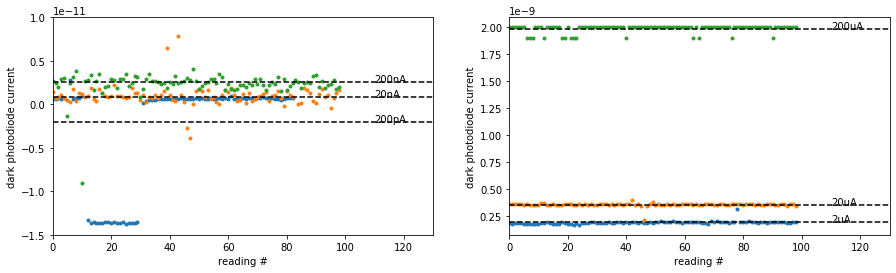

In [14]:
pd_dark_200pA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(58) + ".txt",reg_number=1, material_name='pd_dark_200pA')
pd_dark_20nA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(59) + ".txt",reg_number=1, material_name='pd_dark_20nA')
pd_dark_200nA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(60) + ".txt",reg_number=1, material_name='pd_dark_200nA')
pd_dark_2uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(61) + ".txt",reg_number=1, material_name='pd_dark_2uA')
pd_dark_20uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(62) + ".txt",reg_number=1, material_name='pd_dark_20uA')
pd_dark_200uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(63) + ".txt",reg_number=1, material_name='pd_dark_200uA')

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_diode'],'.')
pd_dark_200pA=np.mean(pd_dark_200pA_df['I_diode'])
plt1.axhline(y=pd_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=pd_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_diode'],'.')
pd_dark_20nA=np.mean(pd_dark_20nA_df['I_diode'])
plt1.axhline(y=pd_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=pd_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_diode'],'.')
pd_dark_200nA=np.mean(pd_dark_200nA_df['I_diode'])
plt1.axhline(y=pd_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=pd_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_ylim(-1.5e-11,1e-11)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark photodiode current')

plt2.plot(pd_dark_2uA_df['I_diode'],'.')
pd_dark_2uA=np.mean(pd_dark_2uA_df['I_diode'])
plt2.axhline(y=pd_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=pd_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_diode'],'.')
pd_dark_20uA=np.mean(pd_dark_20uA_df['I_diode'])
plt2.axhline(y=pd_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=pd_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_diode'],'.')
pd_dark_200uA=np.mean(pd_dark_200uA_df['I_diode'])
plt2.axhline(y=pd_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=pd_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark photodiode current')


# Keithley A (monitor) Dark

Text(0, 0.5, 'dark monitor (KA) current')

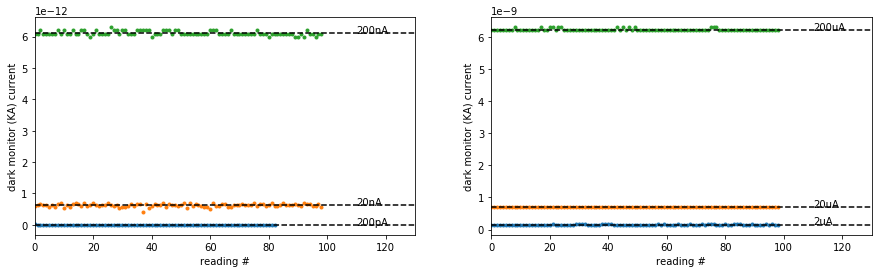

In [22]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_monitor'],'.')
KA_dark_200pA=np.mean(pd_dark_200pA_df['I_monitor'])
plt1.axhline(y=KA_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KA_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_monitor'],'.')
KA_dark_20nA=np.mean(pd_dark_20nA_df['I_monitor'])
plt1.axhline(y=KA_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KA_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_monitor'],'.')
KA_dark_200nA=np.mean(pd_dark_200nA_df['I_monitor'])
plt1.axhline(y=KA_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KA_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark monitor (KA) current')

plt2.plot(pd_dark_2uA_df['I_monitor'],'.')
KA_dark_2uA=np.mean(pd_dark_2uA_df['I_monitor'])
plt2.axhline(y=KA_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KA_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_monitor'],'.')
KA_dark_20uA=np.mean(pd_dark_20uA_df['I_monitor'])
plt2.axhline(y=KA_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KA_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_monitor'],'.')
KA_dark_200uA=np.mean(pd_dark_200uA_df['I_monitor'])
plt2.axhline(y=KA_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KA_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark monitor (KA) current')

# Keithley B (sample) Dark

Text(0, 0.5, 'dark sample (KB) current')

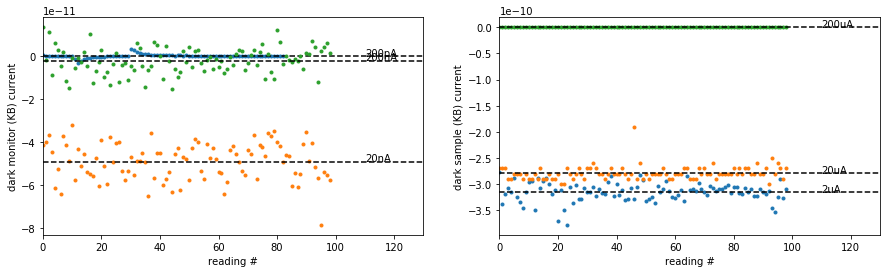

In [24]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_sample'],'.')
KB_dark_200pA=np.mean(pd_dark_200pA_df['I_sample'])
plt1.axhline(y=KB_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KB_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_sample'],'.')
KB_dark_20nA=np.mean(pd_dark_20nA_df['I_sample'])
plt1.axhline(y=KB_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KB_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_sample'],'.')
KB_dark_200nA=np.mean(pd_dark_200nA_df['I_sample'])
plt1.axhline(y=KB_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KB_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark monitor (KB) current')

plt2.plot(pd_dark_2uA_df['I_sample'],'.')
KB_dark_2uA=np.mean(pd_dark_2uA_df['I_sample'])
plt2.axhline(y=KB_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KB_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_sample'],'.')
KB_dark_20uA=np.mean(pd_dark_20uA_df['I_sample'])
plt2.axhline(y=KB_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KB_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_sample'],'.')
KB_dark_200uA=np.mean(pd_dark_200uA_df['I_sample'])
plt2.axhline(y=KB_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KB_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark sample (KB) current')

/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(0, 500)

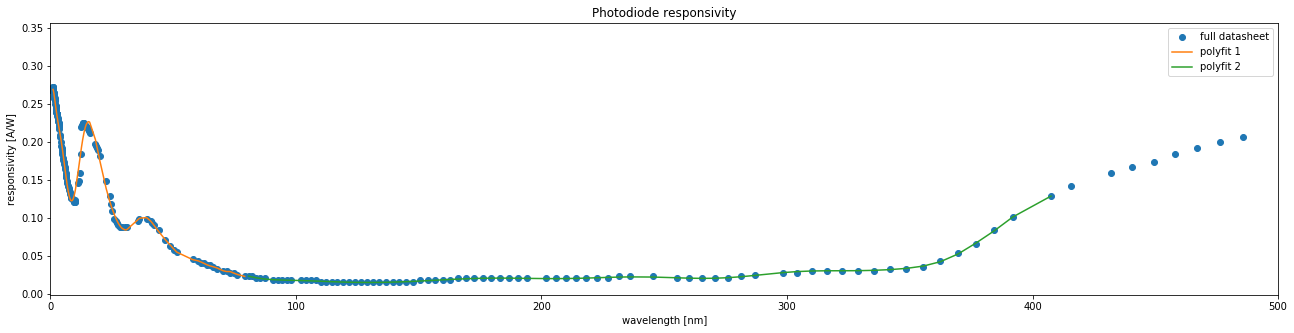

In [9]:
# load photodiode responsivity from a textfile:
wavelength_nm, responsivity = [],[] #responsivity in Amperes per Watt!

filename = "sxuv_responsivity.txt"
startline = 3 #first two lines are useless

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
for i in range(startline-1,len(copy_lines)-1):
    line = copy_lines[i]

    wavelength_nm.append(line[0])
    responsivity.append(line[1])

    #extracted values are still strings --> cast numbers to floats
for i in range(0, len(wavelength_nm)):
    wavelength_nm[i] = float(wavelength_nm[i])
    responsivity[i] = float(responsivity[i])

#plot responsivity
figure(figsize=(22, 5))
plt.plot(wavelength_nm, responsivity, 'o', label="full datasheet")
plt.xlabel('wavelength [nm]')
plt.ylabel('responsivity [A/W]')
plt.title('Photodiode responsivity')

#I want to fit the responsivity function, however, I need not worry about wavelengths above cca 413nm (3eV photon energy)
# so I make a copy of the responsivity up until that wavelength and fit this instead:

threshold_lambda = 80 #wavelength at which polyfit needs to be split into two

lambda_nm_1 = [i for i in wavelength_nm if i <= threshold_lambda]
responsivity_1 = responsivity[:len(lambda_nm_1)] #pick the relevant part of the list

lambda_nm_2 = [i for i in wavelength_nm if i <= 413 and i>threshold_lambda]
responsivity_2 = responsivity[len(lambda_nm_1):len(lambda_nm_1)+len(lambda_nm_2)] #pick the relevant part of the list

responsivity_fit_1 = np.poly1d(np.polyfit(lambda_nm_1, responsivity_1, 23)) #make a polynomial fit for the first region
responsivity_fit_2 = np.poly1d(np.polyfit(lambda_nm_2, responsivity_2, 23)) #make a polynomial fit for the second region

plt.plot(lambda_nm_1, responsivity_fit_1(lambda_nm_1), '-', label="polyfit 1")
plt.plot(lambda_nm_2, responsivity_fit_2(lambda_nm_2), '-', label="polyfit 2")
plt.legend(loc="upper right")

plt.xlim(0,500)

In [10]:
def compute_yield(mat_df=object,PD_df=object,threshold_lambda=int):
    mat_phot_E = np.array(mat_df['phot_E'].tolist())
    PD_phot_E  = np.array(PD_df['phot_E'].tolist())

    mat_I = np.array(mat_df['I_sample'].tolist())
    PD_I  = np.array(PD_df[ 'I_diode'].tolist())

    mat_I_monit = np.array(mat_df['I_monitor'].tolist())
    PD_I_monit  = np.array(PD_df[ 'I_monitor'].tolist())

    print("material df: ",len(mat_phot_E),'\nphotodiode df:',len(PD_phot_E))

    if len(mat_phot_E) == len(PD_phot_E):

        #now I need to split the responsivity factor into two since I'm using two different polyfits of the photodiode responsivity
        R = []
        for i in range(len(PD_phot_E)):
            if convert_eV_to_nm([PD_phot_E[i]])[0]<=threshold_lambda:
                R.append(responsivity_fit_1(convert_eV_to_nm([PD_phot_E[i]]))[0])
            else:
                R.append(responsivity_fit_2(convert_eV_to_nm([PD_phot_E[i]]))[0])

        R = np.array(R)

        TEY = (mat_I/mat_I_monit) * (PD_I_monit/PD_I) * R * PD_phot_E
        
        return TEY

    else:
        print("mismatch in photon energy columns in material and photodiode dataframes!")
        return

# Photodiode LOW, COARSE (3-45 eV, 0.5eV step):

In [11]:
PD_low_file_number = 52 
PD_low_N_of_regs = 7
PD_low_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_low_add_regs_from_file = 0 #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

PD_low_df = concate_regions(file_number=PD_low_file_number,N_of_regs=PD_low_N_of_regs,material_name="PD_low",reject_regions=PD_low_reject_regs,add_regions_from_file=PD_low_add_regs_from_file)
PD_low_df.head()

,phot_E,I_sample,I_monitor,I_diode,reg_number,material_name,KA_range,KB_range,KC_range,real_phot_E
0,3.499998,1.947000e-13,-4.300000e-15,2.200000e-10,1,PD_low,20nA,20nA,2uA,1.947000e-13
1,3.999990,1.805000e-13,-5.300000e-15,2.180000e-10,1,PD_low,20nA,20nA,2uA,1.805000e-13
2,4.499995,1.741000e-13,-2.700000e-15,2.290000e-10,2,PD_low,20nA,20nA,2uA,1.741000e-13
3,4.999990,1.729000e-13,-5.700000e-15,2.820000e-10,2,PD_low,20nA,20nA,2uA,1.729000e-13
4,5.499981,2.068000e-13,3.200000e-15,2.810000e-10,2,PD_low,20nA,20nA,2uA,2.068000e-13


Text(0, 0.5, 'diode current [A]')

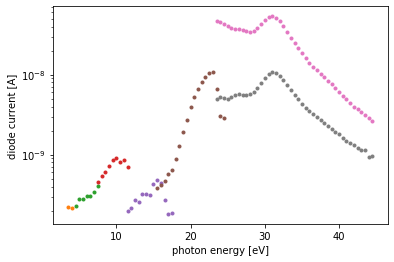

In [12]:
for i in range(8):
    criterion = PD_low_df['reg_number'] == i
    pd_df = PD_low_df.loc[criterion]
    
    plt.plot(pd_df['phot_E'],pd_df['I_diode'],'.')
plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('diode current [A]')

# Photodiode LOW, FINE (3-45 eV, 0.1 step)

Text(0, 0.5, 'diode current [A]')

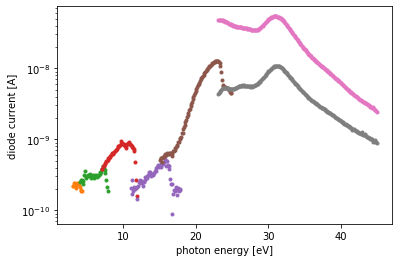

In [35]:
PD_low_fine_file_number = 53 
PD_low_fine_N_of_regs = 7
PD_low_fine_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_low_fine_add_regs_from_file = 0 #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

PD_low_fine_df = concate_regions(file_number=PD_low_fine_file_number,N_of_regs=PD_low_fine_N_of_regs,material_name="PD_low_fine",reject_regions=PD_low_fine_reject_regs,add_regions_from_file=PD_low_fine_add_regs_from_file)

for i in range(8):
    criterion = PD_low_fine_df['reg_number'] == i
    pd_df = PD_low_fine_df.loc[criterion]
    
    plt.plot(pd_df['phot_E'],pd_df['I_diode'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('diode current [A]')

# Photodiode HIGH (40-1500 eV):

Text(0, 0.5, 'diode current [A]')

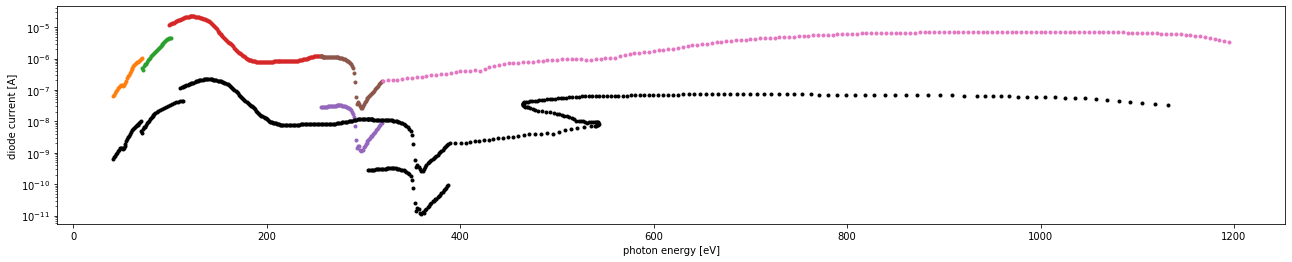

In [36]:
PD_high_file_number = 47
PD_high_N_of_regs = 6
PD_high_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_high_add_regs_from_file = 0 #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

PD_high_df = concate_regions(file_number=PD_high_file_number,N_of_regs=PD_high_N_of_regs,material_name='PD_high',reject_regions=PD_high_reject_regs,add_regions_from_file=PD_high_add_regs_from_file)

figure(figsize=(22, 4))
for i in range(12):
    criterion = PD_high_df['reg_number'] == i
    pd_df = PD_high_df.loc[criterion]
    
    plt.plot(pd_df['phot_E'],pd_df['I_diode'],'.')

for i in range(12):
    criterion = PD_high_df['reg_number'] == i
    pd_df = PD_high_df.loc[criterion]
    
    plt.plot(pd_df['real_phot_E'],pd_df['I_diode']*0.01,'.',color="black")


plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('diode current [A]')

# Gold LOW (3-45eV):

Text(0, 0.5, 'sample current [A]')

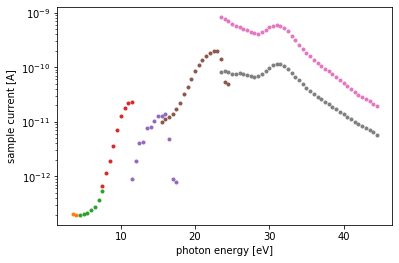

In [74]:
mat_name = 'Gold_low'
mat_file_number = 12
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_file = 0 #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

Gold_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_file=add_regs_from_file)
for i in range(8):
    criterion = Gold_low_df['reg_number'] == i
    pd_df = Gold_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_sample'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')

# Gold HIGH (40-1500 eV)

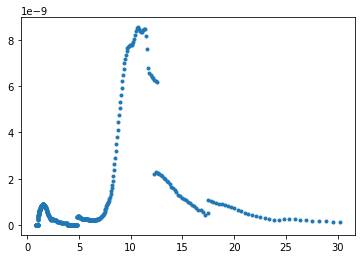

In [57]:
mat_name = 'Gold_high'
mat_file_number = 10
mat_N_of_regs = 6
reject_regs = [5,6] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_file = 11 #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

Gold_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_file=add_regs_from_file)
plt.plot(convert_eV_to_nm(Gold_high_df['phot_E']),Gold_high_df['I_sample'],'.')

# Mg Alloy LOW (fine, 3-45 eV, 0.1eV step)

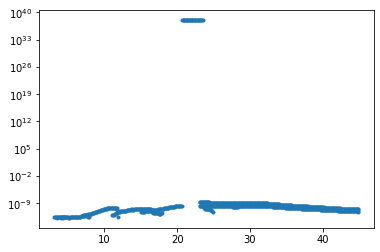

In [58]:
mat_name = 'Mg_alloy_low'
mat_file_number = 24
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_file = 0 #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

Mg_alloy_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_file=add_regs_from_file)

plt.plot(Mg_alloy_low_df['phot_E'],Mg_alloy_low_df['I_sample'],'.')
plt.yscale('log')

material df:  708 
photodiode df: 708


/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


(0, 50)

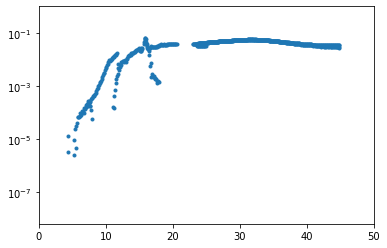

In [76]:
Y_Mg_alloy_low = compute_yield(mat_df=Mg_alloy_low_df,PD_df=PD_low_fine_df,threshold_lambda=80)
Mg_alloy_low_phot_E = np.array(PD_low_fine_df['phot_E'].tolist())
plt.plot(Mg_alloy_low_phot_E,Y_Mg_alloy_low,'.')
#plt.plot(convert_eV_to_nm(phot_E),Y,'.')
plt.yscale('log')
plt.xlim(0,250)
plt.ylim(0,1)
plt.xlim(0,50)

# Mg Alloy HIGH (40-1500 eV, 0.5eV step)

material df:  463 
photodiode df: 463


/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


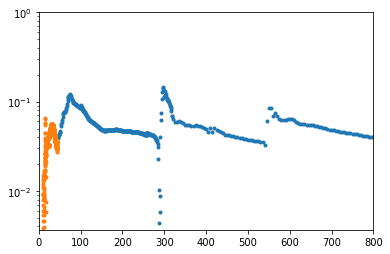

In [89]:
mat_name = 'Mg_alloy_high'
mat_file_number = 19
mat_N_of_regs = 6
reject_regs = [6] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_file = 0 #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

Mg_alloy_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_file=add_regs_from_file)

Y_Mg_alloy_high = compute_yield(mat_df=Mg_alloy_high_df,PD_df=PD_high_df,threshold_lambda=80)
phot_E = np.array(PD_high_df['phot_E'].tolist())
plt.plot(phot_E,Y_Mg_alloy_high,'.')
#plt.plot(convert_eV_to_nm(phot_E),Y,'.')
plt.yscale('log')
plt.xlim(0,800)
plt.ylim(0,1)

plt.plot(Mg_alloy_low_phot_E,Y_Mg_alloy_low,'.')

material df:  136 
photodiode df: 136


/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


(0, 50)

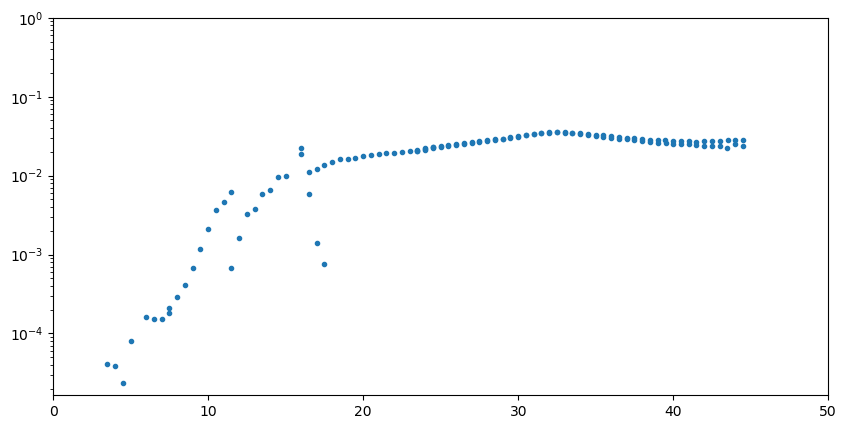

In [64]:
Y_Gold_low = compute_yield(mat_df=Gold_low_df,PD_df=PD_low_df,threshold_lambda=80)
phot_E = np.array(PD_low_df['phot_E'].tolist())
figure(figsize=(10, 5), dpi=100)
plt.plot(phot_E,Y_Gold_low,'.')
#plt.plot(convert_eV_to_nm(phot_E),Y,'.')
plt.yscale('log')
plt.xlim(0,250)
plt.ylim(0,1)
plt.xlim(0,50)